# ECE102 Lab 2: Applications of LTI Filtering

ECE102_v1 - Summer 2020. Report Due: 12pm Aug 7, 2020

This lab is almost entirely copied from EE120 at UC Berkely. Special thanks to Prof. Arcak for making these labs available online and for his permission to use them, Also thanks to all EE120 students/TA's who have helped put these labs together, as shown in the original version history below.

v1 - Spring 2019: Dominic Carrano, Sukrit Arora, and Babak Ayazifar  
v2 - Fall 2019: Dominic Carrano

# Background

Now that you're familiar with the iPython notebook environment and the Python language's scientific computing capabilities, you'll get to put your skills to use in exploring some applications of LTI filtering!

You'll see some examples of filters in this lab that you've probably also seen in class, such as the moving average. The difference here is that since we have a computer to do all the heavy lifting of computing convolutions and plotting things for us, we can explore how these filters behave when given much larger (and more interesting) signals. Specifically, we'll explore these two filters and several different interpretations of how they act on various types of signals, as well as their applications. After that, we'll delve into the MACD indicator, exploring how it's used in analysis of financial data on the stock market.

## Continuous (Interpolated with `plt.plot`) vs Discrete (Stem with `plt.stem`) Plots

While we're still considering our signals as discrete-time entities in this lab, many of them will be fairly long, containing hundreds or even thousands of signal values. As a result, you should **use `plt.plot` for plotting all signals in this lab, unless told otherwise**. 

We used `plt.stem` almost exclusively in Lab 1, but stem plots have two major disadvantages which continuous-time plots (i.e. ones generated with `plt.plot`, which interpolates your signals) don't suffer from:
- It's difficult to overlay multiple signals on the same stem plot and visually compare them.
- Stem plots' rendering times scale *significantly* worse with the length of the signal being plotted.
    - Just to get a sense for how bad a stem plot is at scale, we compared times for plotting with `plt.stem` against `plt.plot` on a 2015 MacBook Pro. On average, for a length 1000 rect, `plt.plot` took ~100 ms and `plt.stem` took 2-3 seconds; for a length 10000 rect, `plt.plot` took ~200 ms and `plt.stem` took 1.5-2 ***minutes***.
    - Remember the demo in Q3c of Lab 1 where we repeatedly convolved rects and saw that we eventually get a Gaussian (the bell curve)? You probably noticed that it took longer and longer to display the successive results - the issue wasn't that the convolutions were taking long due to the signal length increasing (the convolution runtime was increasing with the signal length, but negligibly so); rather the repeated stem plotting was the bottleneck.
    
The two reasons listed above are some reasons why almost all plots you'll see in real world applications are interpolated. Keep in mind that there's actually a more complicated interplay going on between the continuous and discrete realms when doing digital processing of signals:
1. A continuous time signal $x(t)$ is sampled at some rate $T$, giving $N$ samples at integer multiples of $T$ as $x(nT)$. We then define $x[n] = x(nT)$, a discrete time signal, which we can work with on the computer; note that $n = 0,1,..., N-1$ since we only have $N$ samples. Most practical signals are finite in duration, however, and so $N$ can be chosen to be sufficiently high to capture the entire signal.
2. Processing is done on $x[n]$ on a computer, to produce some related signal $y[n]$.
3. $y[n]$ is plotted as a continuous-time signal via interpolation.

Much like the conventions discussed in Lab 1 of what "zero" means as a time index, this is one of the nuances of how signals and systems is done in practice that you get used to with experience.

In this lab, some of the signals we'll use are just made up "test signals" so we can experiment with different filters, in which case the above steps 1-3 aren't relevant. However, in other parts, we'll be using some real world data, and it's good to keep 1-3 straight in your head.

In [31]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from google.colab import drive
drive.mount("/content/drive")
%cd /content/drive/My\ Drive/Colab\ Notebooks

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/My Drive/Colab Notebooks


# Q1: The 1D Edge Detector

The 1D edge detector is used in signal processing to, as you may have guessed from the name, detect edges, or jumps in a signal's amplitude. It's referred to as 1D to distinguish it from 2D edge-detecting filters used in image processing — basic signals only containing amplitude versus time information are referred to as "1D" whereas images are often considered as "2D" signals. Videos are considered "3D" signals, with time (as you go from frame to frame) being the third dimension. Almost all signals you'll see in ECE102 will be 1D.

The impulse response of a 1D edge detector is defined as:

$$h[n] = \delta[n] - \delta[n - 1]$$

In this question, we'll explore several important properties of the edge detector.

The filter works by taking the difference between every pair of adjacent signal values. If you have a sequence of constant values, the filter will repeatedly output zeros, as there's no "edge". 

Similarly, if the signal has a zero (at time $n-1$) followed by a 1 (at time $n$), the filter will output a 1 (at time $n$), indicating an edge of "size" 1. The filter also encodes information about the edge's "direction" - if you instead had a 1 (at time $n-1$) followed by a 0 (at time $n$), the output (at time $n$) would be -1.

Because of this, the 1D edge detector can be thought of as the discrete-time equivalent of taking a derivative, an idea we'll explore in greater depth in part b of this question. 

## Q1a: Piecewise Constant Signals

We'll go through two examples with this filter. First, we'll try it out on a piecewise constant signal. We call a DT signal "piecewise constant" if it consists only of constant-height segments each spread over more than one sample. The first two signals below are piecewise constant; the third is not.

<img src="q1pic.png" width="1200px" />

### Your Job

In the cell below:  
- Using the time indices $\{0, 1, ..., 19, 20\}$, define the piecewise constant signal $x$ as  

$$x[n] = \sum_{k = 5}^{9} \delta[n - k] + 3\sum_{k = 10}^{13} \delta[n - k] + 2\sum_{k = 14}^{18} \delta[n - k]$$  


- Define the edge detector's impulse response $h$, but only at its nonzero points (so that the numpy array representing $h$ contains two elements).
    - Throughout this lab, we'll typically be defining our impulse responses over their nonzero points to avoid offset issues and using "same" for convolution. As you saw in Lab 1, "same" truncates convolved signals to the same length as the longer of the two arguments, cutting out points from the result's edges. Essentially, "same" acts just like "full" but with some truncation; we'll be zero padding the input signals as necessary to handle this.
- Compute $y = x * h$ using "same" for the convolution mode.
- Once done with the previous three steps, run the cell to plot the results (plotting code has been provided for you).  

In [32]:
# TODO your code here

import scipy.signal as sp
def delta(n):
  count = 0
  d = np.zeros(np.shape(n))
  for i in n:
    if i == 0:
      d[count] = 1
    count = count+1
  return(d)

def sumdelta(start,stop):
  sig = 0
  while start<=stop:
    sig = sig + delta(n-start)
    start = start+1
  return sig


n = np.arange(0,21,1,dtype=int)
h = np.array([1,-1])
x = (sumdelta(5,9))+(3*sumdelta(10,13))+(2*sumdelta(14,18))
y = np.convolve(x,h, mode='same')

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.
  """
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.
  # Remove the CWD from sys.path while we load stuff.


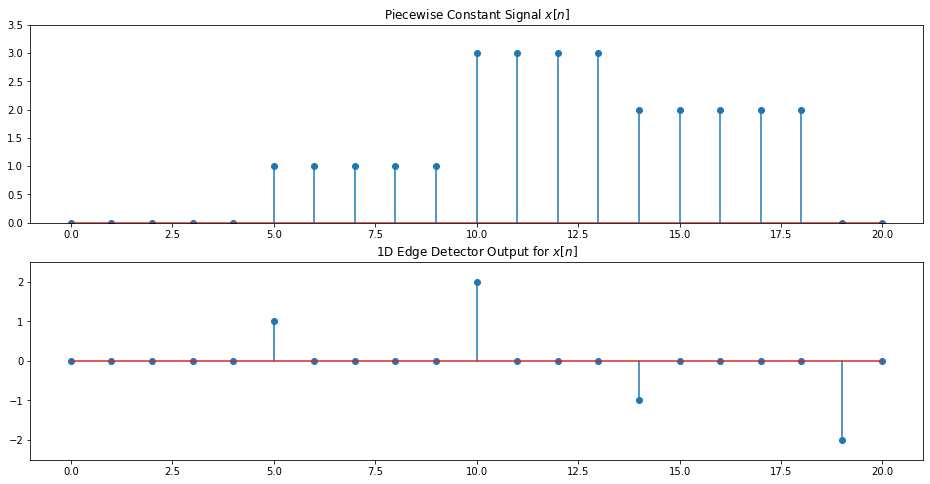

In [33]:
# Plot results
plt.figure(figsize=(16, 8))

plt.subplot(2, 1, 1)
plt.stem(n, x)
plt.ylim([0, 3.5])
plt.title("Piecewise Constant Signal $x[n]$")

plt.subplot(2, 1, 2)
plt.stem(n, y)
plt.ylim([-2.5, 2.5])
plt.title("1D Edge Detector Output for $x[n]$")

plt.show()

**Q:** $x$ is a piecewise-constant signal, changing a total of four times: once from 0->1, then 1->3, then 3->2, and finally 2->0. How many points of the edge detector's output are nonzero (that is, how many edges are detected)?

<span style="color:blue">**A:** 4 edges are detected. </span>

**Q:** One of the hottest areas of signal processing in the past ~15 years has been the study of sparse (mostly zero) signals, including both acquisition and representation, known as *compressed sensing*. A key part of compressed sensing algorithms is applying some *sparsifying transform* to signals that retain all the signal's information (i.e., the original signal could be completely recovered from the transformed one) but result in a new signal that is mostly zero. 

Suppose you're interested in developing compressed sensing algorithms for piecewise constant signals, and are in need of a way to sparsify them. How would you do so by only using the first signal value, $x(0)$, and using an LTI filter of your choice as the sparsifying transform? Explain both what LTI filter you would use, and how to recover the original signal from the filtered one. You can ignore noise that would be present for real world signals — assume the signal truly is piecewise-constant like the ones above. Also, you may assume $x(n) = 0$ for $n < 0$, since this is basically what we're doing in the digital setup.

<span style="color:blue">**A:** You can use a 1D edge detector filter when dealing with piecewise functions to do this, the resulting signal would be mostly zeros but the original signal can be constructed again using the edge data available in the new signal.  </span>

## Q1b: The Edge Detector as a DT Differentiator

The 1D edge detector is sometimes also referred to as a *moving difference* filter, since it operates by subtracting adjacent points. This has a particularly nice connection to the idea from calculus of taking a derivative of a function, and many properties of the 1D edge detector can be discovered by considering it as a discrete-time analogue of taking a signal's derivative. 

Recall that given a function $f: \mathbb{R} \xrightarrow{} \mathbb{R}$, the derivative of $f$ is defined as

$$f'(t) = \lim_{\Delta t \xrightarrow{} 0}\dfrac{f(t + \Delta t) - f(t)}{\Delta t}$$

and as we make $\Delta t$ smaller and smaller, we get better and better approximations of $f'(t)$. But in DT, all arguments to our signals have to be integers, so $\Delta t$ has to be an integer. The smallest it could then be, without actually being zero, is 1, in which case we recover the formula for the 1D edge detector!

Let's revisit some of the classic results you saw in your first calculus class, but instead of using functions that take real numbers as inputs, we'll use DT signals.

### Your Job

In the cell below:
- Create a length 50 *ramp signal* $r$, defined as
$$r[n] = \sum_{k=1}^{50} k \delta[n - k] = \delta[n - 1] + 2 \delta[n - 2] + 3 \delta[n - 3] + ... + 50 \delta[n - 50]$$
- Compute $y = r * h$, where $h$ is the (non zero-padded) 1D edge detector's impulse response, just as in Q1a. **Use "valid" as the convolution mode** - we only want to difference values from our actual signal (i.e. where $x$ and $h$ fully overlap).
- In separate figures (or you can use two subplots inside the same figure as was done in the provided code for Q1a; up to you), one above the other, plot $r$ and $y$ (plot $r$ on the top figure and $y$ on the bottom one). A few instructions regarding your plot:
    - **Use `plt.stem` to make stem plots**.
    - Give your plots reasonable titles.

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.
  from ipykernel import kernelapp as app
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:19: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.


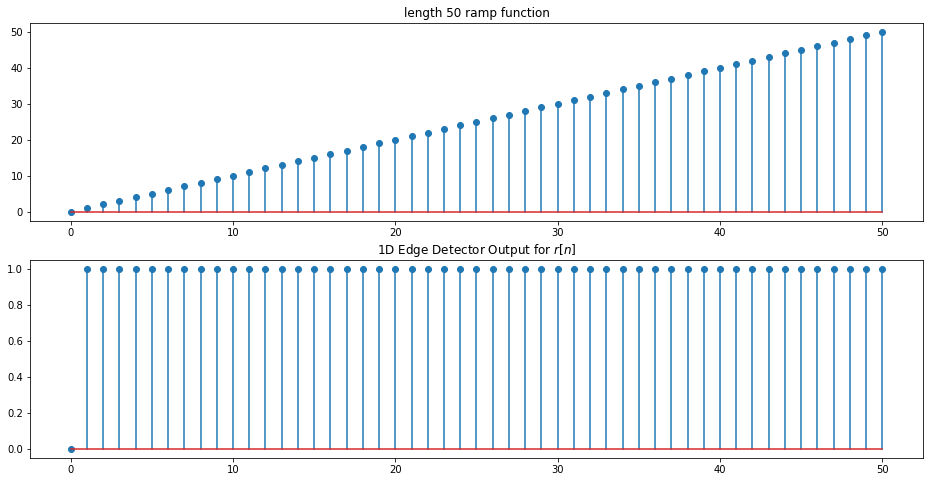

In [34]:
# TODO your code here

def Ksumdelta(start,stop):
  sig = 0
  while start<=stop:
    sig = sig + (start*delta(t-start))
    start = start+1
  return sig
t = np.arange(0,51,1,dtype = int)
r = Ksumdelta(1,50)
y = np.convolve(r,h,mode= 'same')

plt.figure(figsize=(16,8))
plt.subplot(2, 1, 1)
plt.stem(t,r)
plt.title("length 50 ramp function")

plt.subplot(2, 1, 2)
plt.stem(t,y)
plt.title("1D Edge Detector Output for $r[n]$") 
plt.show()


**Q:** A ramp signal linearly increases. You should see in your plot that a 1D edge detector, or moving difference, outputs a constant signal when given a ramp as its input. What real function ($f(t) = ?$) does the ramp remind you of? What is that function's derivative (what's $f'(t)$)? How does the derivative for it match up against the edge detector's output?

*italicized text*<span style="color:blue">**A:** Ramp is similar to a linear increasing function and the derivative of a linear function is 1.</span>

Let's do another! In the cell below:
- Create a length 51 quadratic signal $x[n] = n^2$ for $n = 0, 1, ..., 50$.
- Compute $y = r * h$ just as you did in the previous example, where $h$ is the (unpadded) 1D edge detector's impulse response. Again, use "valid" for the mode.
- Plot $x$ and $y$ the same way you plotted $r$ and $y$ in the previous example, in separate plots with $x$'s above $y$'s.

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.
  


<function matplotlib.pyplot.show>

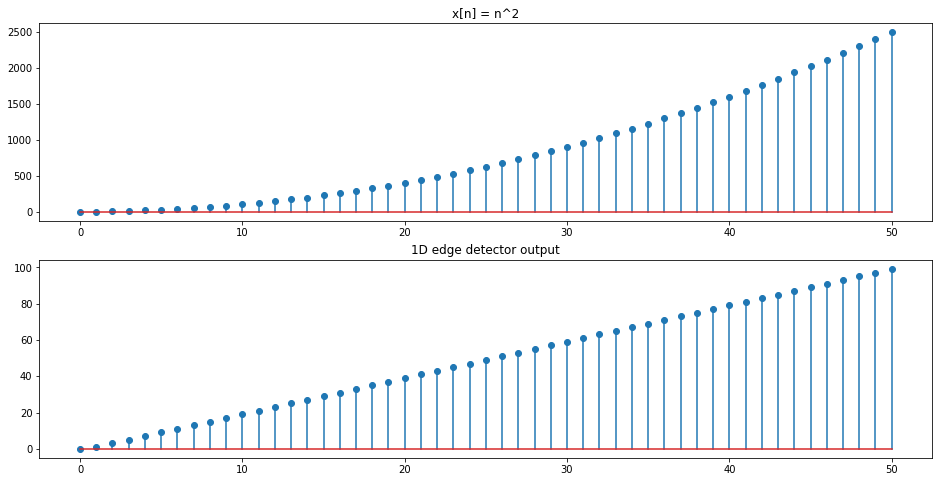

In [35]:
# TODO your code here
import math
n = np.arange(0,51,1,dtype=int)
x = np.square(n)
y = np.convolve(x,h,mode = 'same')

plt.figure(figsize=(16,8))

plt.subplot(2,1,1)
plt.stem(n,x)
plt.title("x[n] = n^2")

plt.subplot(2,1,2)
plt.stem(n,y)
plt.title("1D edge detector output")

plt.show

**Q:** Same question as before. You should see in your plot that a 1D edge detector, or moving difference, outputs a ramp signal when given a quadratic as its input. What real function ($f(t) = ?$) does the quadratic remind you of? What is that function's derivative (what's $f'(t)$)? How does the derivative for it match up against the edge detector's output?

<span style="color:blue">**A:** The function is a one sided parabolic fuction and the derivative is linear with explains the ramp function in the output.</span>

## Q1c: "Differentiating" Noise

Now that we've tried our edge detector on a piecewise constant signal, let's try it on a less well-behaved signal: some noise! In this part, as well as the moving average filter, we'll use what's commonly referred to as "Gaussian noise" as our test signal. 

### What is this "noise" you speak of?

In many real-world applications, when using some data that has been collected (i.e., a signal), you don't have access to the original signal (call it $x$). Instead, you have access to $\tilde{x} = x + z$, where $z$ is "noise" that corrupts the signal. A large part of signal processing, machine learning, statistics, data science, and many other application areas involves extracting as much meaning as possible from the measured signal $\tilde{x}$. A popular choice for modeling $z$ is what's known as "Gaussian noise". The name comes from the fact that the noise itself is random, and so it has to be drawn from some probability distribution, which in this case is the Gaussian distribution. The justification for this choice is due to the [Central Limit Theorem](https://en.wikipedia.org/wiki/Central_limit_theorem), since in many cases, the noise riding on top of a signal is a superposition of a large number of various random factors. For example, the [thermal noise](https://en.wikipedia.org/wiki/Johnson%E2%80%93Nyquist_noise) in electronics from interactions between particles as they bounce around and hit each other has been found to be very close to Gaussian, which makes sense, as the number of individual atoms involved is large, with each pair of interacting atoms serving as a separate random event.

As was mentioned in Lab 1, you don't need to know probability theory for this class. But due to the popularity of the Gaussian noise model in signal processing, it's worth experimenting with as a test signal.

### Your Job

The signal `noise` is defined for you below: 

In [36]:
noise = np.random.normal(0, 5, 1000) # 1000 samples of mean=0, stddev=5 gaussian noise


Now, add code to apply the (unpadded, i.e. the numpy array is length 2) edge detector to it, and store the result in `noise_filt`. Again, use "valid" as the convolution mode. Plotting code has been provided for you. You don't have to do much coding for this part.

Note that we'll start using `plt.plot` from here on out. We'll be using longer signals (we generated 1000 samples of noise) and in addition to `plt.plot` being more efficient, it'll be much easier to visualize our results, as mentioned in "Background".

In [37]:
# TODO your filtering code here; store result in noise_filt
noise_filt = np.convolve(noise,h,mode='same') # filtered result

NOTE: The signals `noise_filt` and `noise` will not necessarily fit within the -20 to 20 y-limits we've set for the plot. Since it's random, it's possible we'll draw values that, either before or after filtering, will go outside these limits.

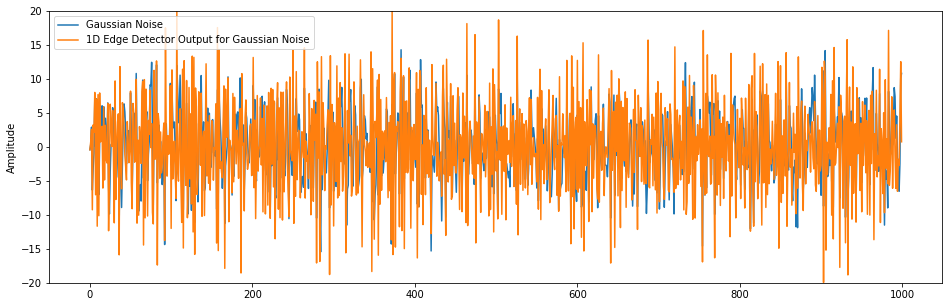

In [38]:
# Plot results
plt.figure(figsize=(16, 5))
plt.plot(noise)
plt.plot(noise_filt)
plt.ylim([-20, 20])
plt.ylabel("Amplitude")
plt.legend(("Gaussian Noise", "1D Edge Detector Output for Gaussian Noise"))
plt.show()

**Q:** Qualitatively, does the filter amplify or suppress the "strength" of the noise? What implications might this have if we want to detect edges on a signal that has been corrupted by a large amount of noise?

<span style="color:blue">**A:** The filter amplifies the strength of the noise in the signal. we can find places where intensity is changing rapidly. We want to find peaks, because in the neighborhood of an edge, after smoothing, there may be many points of the signal that is changing rapidly, but we only want to identify one of them as the edge.</span>

# Q2: Data Smoothing

One of the most common uses of LTI filters is in data smoothing. The applications are numerous, ranging from noise reduction, to extracting trends from complex data, to interpolation, and more. In this question, we'll explore the simplest, yet perhaps most widely used, data smoothing method in a few of these application spaces: a moving average filter.

## Q2a: Noise Reduction

The *simple* moving average filter is specified in terms of a single integer parameter, $L$, which represents the length of the filter. The filter takes the average of the $L$ points before, and including, the current point of a signal, outputting that average. Formally, the filter's impulse response is:

$$h_{SMA}[n] = \frac{\delta[n] + \delta[n - 1]\ +\ ...\ +\ \delta[n - (L - 1)]}{L}$$

Note that the definition we'll use here is for the *causal* moving average filter: the output at any point in time is only computed as an average of the current and previous signal values. You probably recognize the impulse response - it's just a length $L$ rect normalized to sum to 1. 

The subscript "SMA" in the impulse response definition stands for *Simple Moving Average*, meaning all points are given equal weight in computing the average. This distinguishes the filter from more elaborate moving averages, such as the *Exponential Moving Average* (EMA) which gives more recent data points a higher weight. You'll get a chance to explore the EMA later in this Lab. We encourage you to check out reference [1] for more on the theory behind the use of moving average filters for noise reduction if interested.

### Your Job: Signal Generation

In the cell below, do the following:
- Generate the time indices $\{0, 1, ..., 999, 1000\}$.
- Generate the signal $x[n] = e^{n / 300}$ over these time indices.
- Append 500 zeros onto the end of $x$, and extend your time indices to account for these extra data points. That is, your time indices should now be $\{0, 1, ..., 1000, 1001, ..., 1500\}$.
- Generate noise $z$ of the same dimensions as $x$, by using [np.random.normal](https://docs.scipy.org/doc/numpy/reference/generated/numpy.random.normal.html) with the parameters `loc=0, scale=4, size=np.shape(x)`. 
    - As a reminder from Lab 1 Q1, `np.shape(x)` returns how many entries `x` has along each dimension (here, our signal is 1D, so `np.shape` just returns the number of entries), which we can pass into a numpy function to easily generate numpy arrays (i.e. signals) of the same size as some other numpy array. 
- Create the noised signal $y = x + z$.
- On the same 16x4 figure, plot $x$ and $y$. Using [plt.legend](https://matplotlib.org/3.1.0/api/_as_gen/matplotlib.pyplot.legend.html), label $x$ as "True Signal" and $y$ as "Noised Signal". **Make sure you use `plt.plot`, *not* `plt.stem`, for plotting.** You should use the time indices you generated as the first argument to `plt.plot`.

Text(0.5, 1.0, 'exponential signal with padding')

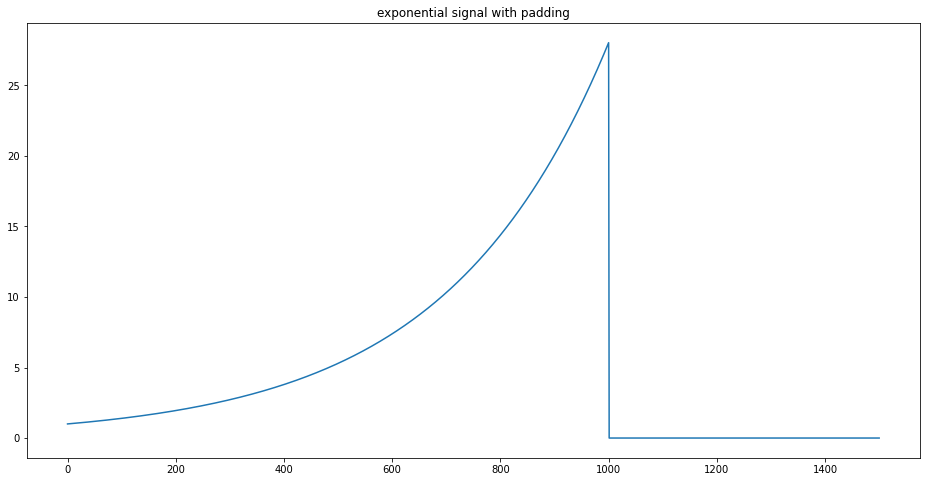

In [39]:
# TODO your code here
n = np.arange(0,1001,1,dtype = int)
x = np.exp(n/300)
t = np.arange(0,1501,1,dtype=int)
y = np.append(x,np.zeros(500))
plt.figure(figsize = (16,8))
plt.plot(t,y)
plt.title("exponential signal with padding")

If your code is correct, you should see an exponential that rises in amplitude from 0 to ~30 over the course of the first 1000 samples followed by 500 zeros. Overlayed on top of it, you'll see a signal that jumps up and down, **but, on average, follows the sample amplitude as the original signal.**

### Your Job: Signal Denoising

Now that we've got a (not so) nice and noised up signal, let's try to denoise it with a moving average. Intuitively, since the noised signal follows, on average, the original one, we should be able to reduce the noise a bit by averaging adjacent data points. The hard part, and a great example of an engineering tradeoff, is figuring out the right number of points to average at a time. 

The array `filt_sizes` containing the different sizes (the parameter $L$ from above) we'll try out has been defined for you. In the cell below:
- Create a 20x35 figure. We will be creating a column of subplots, one for each filter length (note `len(filt_sizes)` is 7).
- For each filter size in `filt_sizes`,
    - Create a simple moving average filter, $h$, of that size.
        - Don't bother doing any zero padding of $h$. Instead, just construct the filter for all points where it is nonzero.
    - Compute $\hat{x} = y * h$, where $y$ is the noised growing exponential signal you created above. Naming this variable `x_hat` in your code is fine. **Use "full" as the convolution mode.** If we don't use "full", the filter will be non-causal due to the way we defined the impulse response. 
    - On a new subplot (that is, for each different moving average filter, we're using a separate subplot):
        - Plot $x$, the original (noiseless) signal. You can use the variable $n$ from above for the time indices.
        - Plot $\hat{x}$, the moving averaged version of $y$ you computed in the current loop iteration. 
            - Since we didn't use "same" for the convolution (motivated by the desire to have a causal filter), we need an expanded set of time indices to plot with. 
            - As a freebie, the code for this is `n_aug = np.concatenate((n, np.arange(n[-1], n[-1] + (len(x_hat) - len(n)))))`. This just adds on the extra indices to the end of the existing ones based on how much the convolution stretches the signal $x$ by.
        - Use `plt.legend` to label $x$ as "True Signal" and $\hat{x}$ as "Noised Signal after ?-point SMA", where "?" should be replaced by the current filter size. Python's [format](https://www.digitalocean.com/community/tutorials/how-to-use-string-formatters-in-python-3) function may be of use here.

**Note:** $\hat{x}$ and $h$ change with each new filter size; $x$ and $y$ do not.

**Hint 1:** It will be most informative to display our subplots as a column. Thus, your call to `plt.subplot` should look something like `plt.subplot(len(filt_sizes), 1, i)`  where `i` is a variable tracking which subplot we're currently on (i.e., it starts at 1, and should increase by 1 each time we create and apply a different moving average filter).

**Hint 2:** Make sure to call `plt.show()` *after* you've created all your subplots (i.e., it should NOT be called inside a loop). You only call `plt.show()` once per figure, i.e. after you're finished generating all the subplots.

In [20]:
filt_sizes = [2, 5, 10, 20, 50, 100, 500]

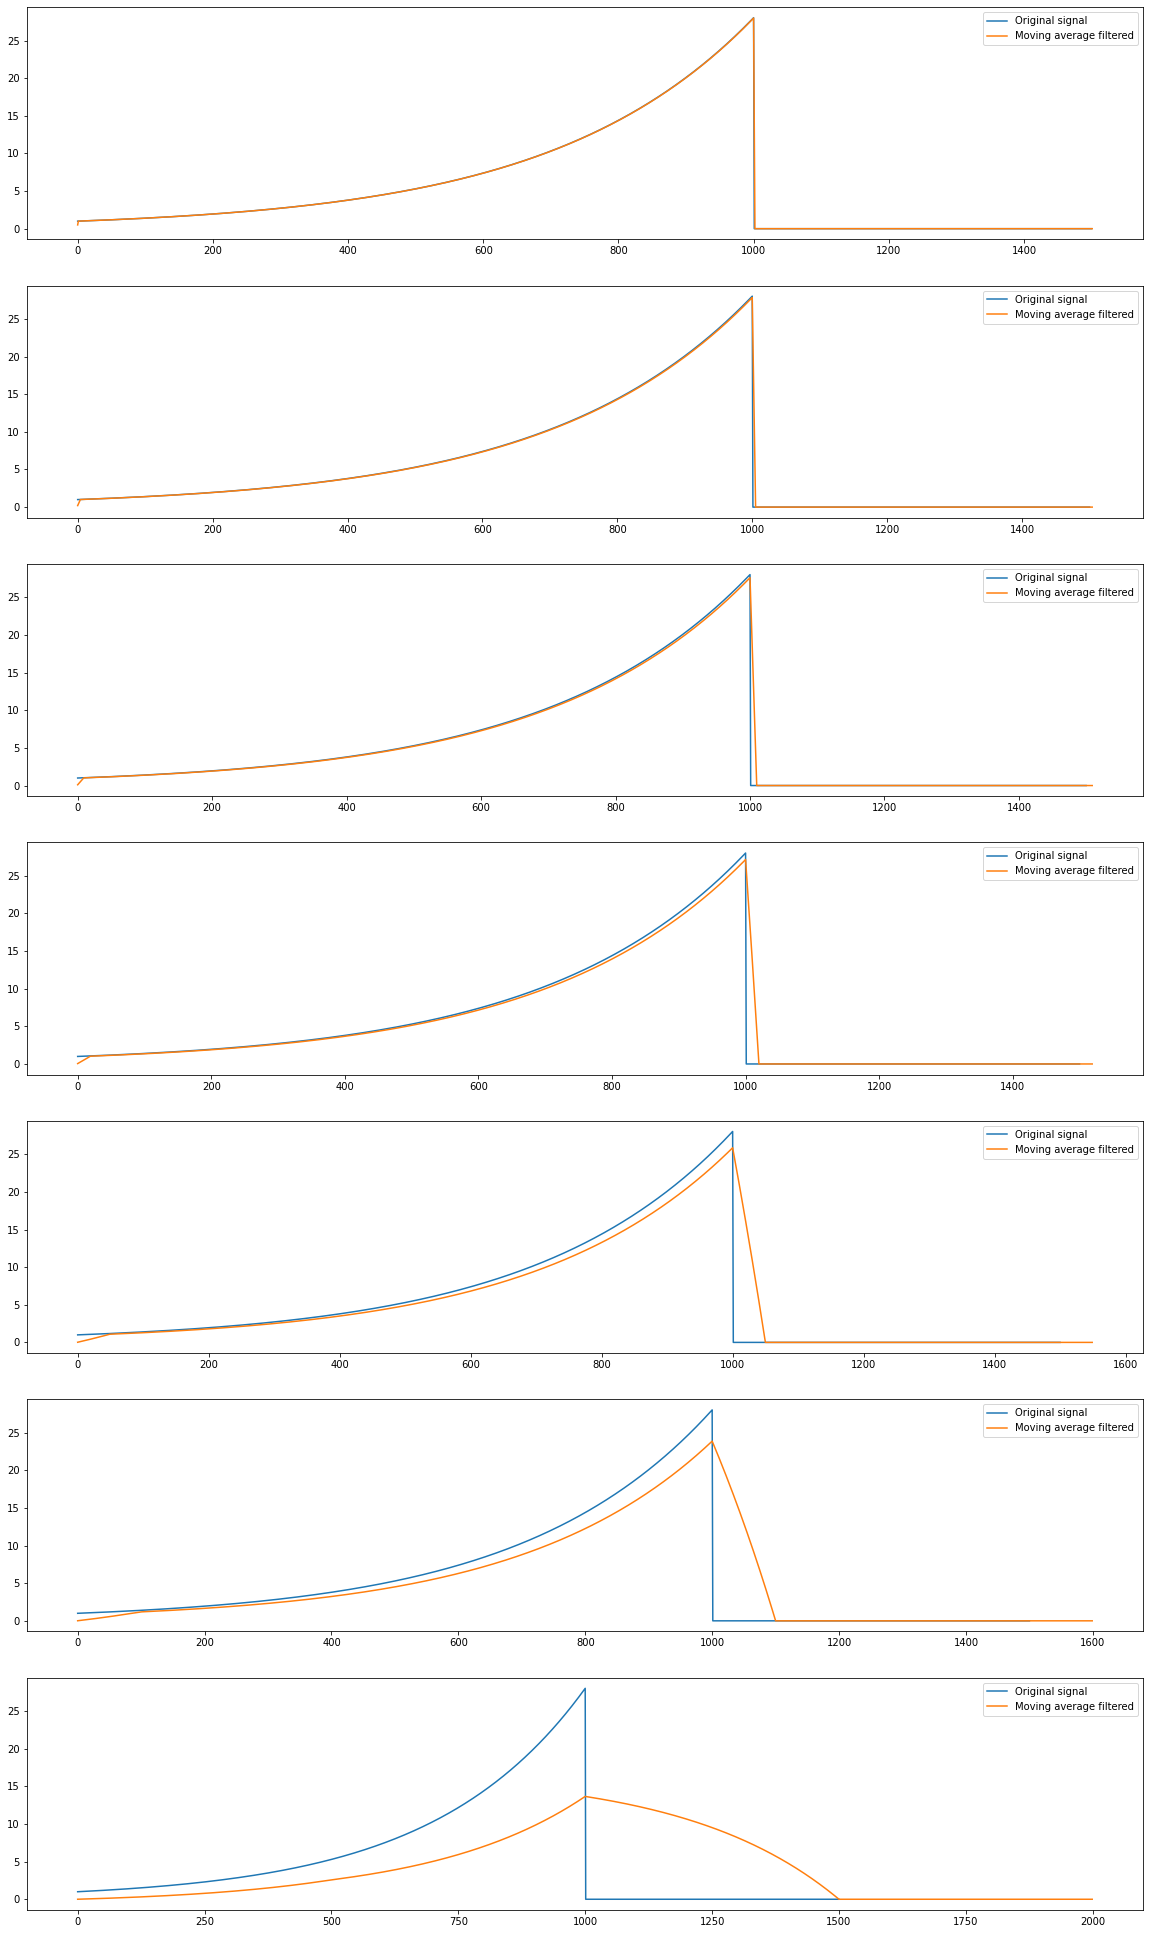

In [46]:
# TODO your code here
#moving average filter


def MAF(filt_size):
  o = np.ones(filt_size,dtype=int)
  o = o/filt_size
  return o

w = 1
plt.figure(figsize = (20,35))

for i in filt_sizes:
  h = MAF(i)
  c = np.convolve(h,y,mode='full')
  plt.subplot(7,1,w)
  plt.plot(t,y)
  plt.plot(c)
  plt.legend(("Original signal","Moving average filtered"))
  w = w+1
plt.show()

  



A few sanity checks:
- In all cases, the true signal should go from 0 to 1500 and look the same.
- As we increase the filter length, the noised signal (post-filtering) will be stretched further and further out, occupying just over 1500 points for the length 2 and length 5 filters, and about 2000 points for the length 500 filter.
- The peak of the noised signal (post-filtering) should always line up with the true signal's peak. This is a good sanity check that the filter is causal: if it doesn't look ahead, then the filter's first encounter with the peak will be averaging the peak with the previous (positive) values, resulting in a peak in the output. After the filter sees the true signal's peak, it only sees zeros, so averaging in more and more zeros instead of the positive values on the exponential will lead to smaller and smaller output values.

### Analyzing the plots

**Q:** As we increase the filter length, do the first 400-500 points of the filtered signal get smoothed out (reducing the noise at these points) or blown up (amplifying the noise)? Ignore any scaling differences; that is, if the filtered signal looks the same as the true one except for being off by a constant scaling factor, that's fine.

*italicized text*<span style="color:blue">**A:** The filtered signal is smoothed out</span>

**Q:** As we increase the filter length, what happens to our signal's sharp, high-frequency feature, the drop off from the top of the exponential back down to zero (at $n=1000$)? Is this high-frequency feature preserved, or does it get more and more distorted? Explain, based on the moving average filter, why this makes sense.

**bold text**<span style="color:blue">**A:** as we increase the filter length it becomes more of a gradual drop rather than sharp this is because the amplitude of the fiter gets much lower as the length increases.</span>

**Q:** Putting your previous answers together, what advantage is there to using a longer moving average for noise reduction? What do we have to trade off (i.e., what disadvantage becomes more and more pronounced) in doing so?

bold text<span style="color:blue">**A:** Using a longer moving average reduces the noise better and it is optimal but it has inflexible frequency response. Nudging a conjugate zero pair results in non-unity coefficients.</span>

**Q:** Assuming you equally prioritize minimizing distortion of sharp, high-frequency features while still getting a reasonable amount of noise reduction, which of the following moving average filter lengths would you pick from above for denoising this specific signal? There are multiple correct answers; just be sure to justify your choice.

<span style="color:blue">**A:** the length 100 provides enough information about the drop also smoothens the drop by a reasonable amount.</span>

## Q2b: Extracting Trends from Data

In addition to its use in signal processing and statistics for noise reduction, the moving average filter is popular in analysis of financial data for highlighting trends in stock prices.

Here, we'll analyze one of the most common datasets in time series analysis: stock price data! Run the cell below to load it. We will be taking a look at Apple's stock data from mid 2017 to early 2019.

We got this data from Yahoo! finance. If you are interested in playing around with stock data on your own, you can click on a stock, navigate to the historical data tab, download a csv file, and use our code below to parse it. Acquiring data often plays second fiddle to all the fancy algorithms used on it despite being just as important a part of any engineering field that relies on it. However, here, we want to focus on the algorithms, not the minutiae of Yahoo! csv file formats, hence why we provide the code to read the data in.

In [47]:
# CSV hocus pocus
import csv

stock_dates = []
stock_prices  = []
with open("AAPL.csv", mode='r') as raw_data:
    csv_reader = csv.DictReader(raw_data)
    for row in csv_reader:
        data = row['Close']
        if not data == 'null':
            stock_prices.append(float(data))
            stock_dates.append(row['Date'])
stock_prices = np.array(stock_prices)

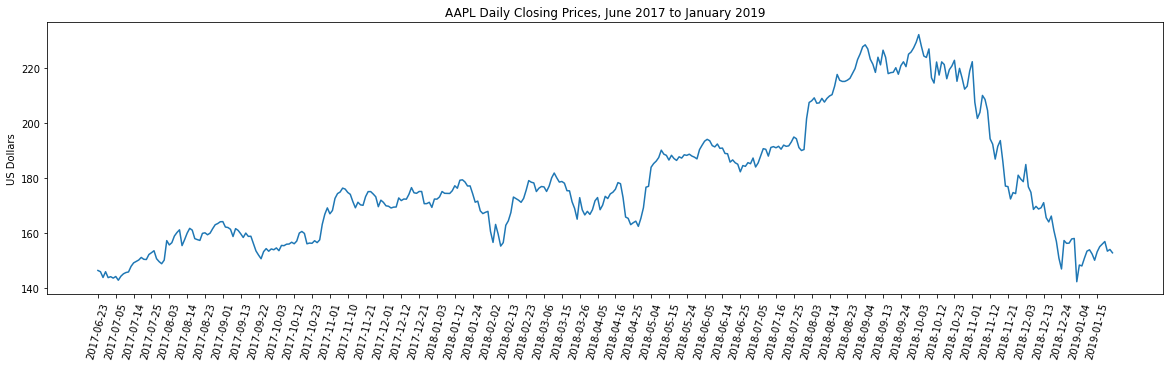

In [48]:
# 400 most recent days
start = -400
end = -1
x = np.arange(len(stock_prices[start:end]))

# Plot roughly one data point per week (x[::7]) so we can display dates 
# without matplotlib going crazy about the labels overlapping
plt.figure(figsize=(20, 5))
plt.xticks(x[::7], stock_dates[start:end:7], fontsize=10, rotation=75)
plt.plot(x, stock_prices[start:end])
plt.title("AAPL Daily Closing Prices, June 2017 to January 2019")
plt.ylabel("US Dollars")
plt.show()

### Your Task

Your job is to fill in the missing parts of the cell below to filter the noise with moving average filters of length 5, 25, and 75, and be sure to answer the question about interpreting the results below the cell. Unlike Q2a, most of the work has been done for you here.

In the cell below:
- Define the moving average impulse responses as `MA5, MA25, MA75` respectively.
    - Again, don't bother with any zero padding - just define them at their nonzero points.
- Filter your test data (`data`) with each of them using **convolution with the "same" mode**. We'll call the outputs `y5, y25`, and `y75`, respectively.

*Note:* **Here, we are *not* using causal moving averages as we did in Q2a.** The motivation in doing so is that we want the filtered signals to temporally align with the original to make the results easier to interpret. While real-time filters have to be causal, we're working in an offline setting with pre-collected data here, so causality is less important, and interpretability is more useful. These properties are some of the tradeoffs involved in how data processing is done.

Plotting code has been provided for you. To generate the results, simply run the cell after adding your own code.

In [49]:
data = stock_prices[start:end]

In [50]:
## TODO your impulse response definitions here
MA5 = MAF(5)
MA25 = MAF(25)
MA75 = MAF(75)

In [51]:
## TODO your filtering code here
y5 = np.convolve(MA5,data,mode='same')
y25 = np.convolve(data,MA25,mode='same')
y75 = np.convolve(data,MA75,mode='same')

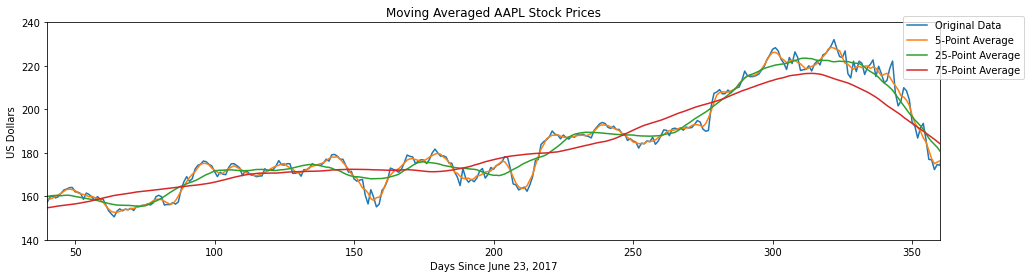

In [52]:
# Overlay stock prices
plt.figure(figsize=(16, 4))
plt.plot(np.arange(len(data)), data)
plt.plot(y5)
plt.plot(y25)
plt.plot(y75)

# Formatting mumbo jumbo to abstract away boundary issues
plt.xlim([40, 360])
plt.ylim([140, 240])
plt.legend(('Original Data', '5-Point Average', '25-Point Average', '75-Point Average'), bbox_to_anchor=(1.1, 1.05))
plt.ylabel("US Dollars")
plt.xlabel("Days Since June 23, 2017")
plt.title("Moving Averaged AAPL Stock Prices")
plt.show()

**Q:** As we use longer and longer moving average filters to process our signal (the stock data), does the filtered signal highlight longer term trends, or shorter term trends? Explain in 1-2 sentences.

<span style="color:blue">**A:** The long term trend is highlighted as the short term trend is smoothed out.</span>

**Q:** Suppose that you had the closing price of Microsoft stock (MSFT) for every day it's existed, 1986 to present (~8000-10000 data points, one per day), and wanted to see how the company's stock price changed at the level of trends that occur over the course of a year using a moving average filter. How long of a moving average would you use? Why?

**bold text**<span style="color:blue">**A:** i would use a length 100 Moving average filter</span>

# Q3: The MACD Indicator

The Moving Average Convergence Divergence (MACD) Indicator is a trend-following momentum indicator that shows the relationship between two moving averages of a stock’s price. In this question, we'll use the MACD indicator as a vehicle for introducing the exponential moving average as well as some more uses of signal processing in financial analysis.

## The Exponential Moving Average

To calculate the MACD of a stock, we first have to understand a new kind of moving average, called the *Exponential Moving Average* (EMA). What we did earlier is known as an Simple Moving Average (SMA) - all points are given equal weight. An EMA, on the other hand, places a greater weight, and therefore significance, on the most recent data points. The benefit of the EMA over the SMA is that the EMA reacts faster to recent price changes. 

### Derivation

Let's take a look at where the EMA comes from. We can express the EMA using the following recursive LCCDE: 

$$y[n]=\alpha\cdot x[n] + (1-\alpha)\cdot y[n-1]$$

where $y[n]$ is the EMA at day $n$, and $x[n]$ is the stock price at day $n$. Now, why is this an "exponential" moving average? It might not be obvious when written it in this form. Let's write it out step by step to try to unravel the recursion. Assuming that $y[n]$ is zero $\forall n<0$,

$\begin{aligned}
    y[0] &= \alpha\cdot x[0] + (1-\alpha)\cdot y[-1] = \alpha\cdot x[0] \\
    y[1] &= \alpha\cdot x[1] + (1-\alpha)\cdot y[0] = \alpha\cdot x[1] + (1-\alpha)\cdot \alpha\cdot x[0] \\
    y[2] &= \alpha\cdot x[2] + (1-\alpha)\cdot y[1] = \alpha\cdot x[2] + (1-\alpha)\cdot (\alpha\cdot x[1] + (1-\alpha)\cdot \alpha\cdot x[0]) = \alpha\cdot x[2] + (1-\alpha)\cdot \alpha\cdot x[1] + (1-\alpha)^2\cdot \alpha\cdot x[0] \\
    &\vdots \\
    y[n] &= \alpha\sum_{k=0}^{n}(1-\alpha)^k\cdot x[n-k]
\end{aligned}$

Aha! Now that we have rewritten it, it's clear why we call this an EMA - we are weighting each previous data point with an value that decreases exponentially as we go further and further back in time.

### An LTI Perspective: The Impulse Response of an EMA Filter

We can apply a Kronecker delta to the EMA system by setting $x[n] = \delta[n]$ to find its impulse response:

$$h[n]=\alpha\sum_{k=0}^{n}(1-\alpha)^k\cdot \delta[n-k]= \alpha (1-\alpha)^n u[n]$$

which is just what we would expect: a (one-sided) decaying exponential!

## Your Job

Fill in the `ema_filter` function below to create and return the impulse response of an EMA filter truncated after `length` points. The value of $\alpha$ has been determined for you already. **Make sure you normalize the impulse response to sum to 1.**

In [76]:
import math

def ema_filter(length):
    alpha = 2/(length+1)
    h = 0
    n = np.arange(0, length, 1,dtype = int)
    # TODO: Create and return an EMA filter with length "length"
    u = np.ones(length)
    for i in n:
      u[i] = u[i] * alpha*math.pow((1-alpha),i)
    return(u)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.
  """


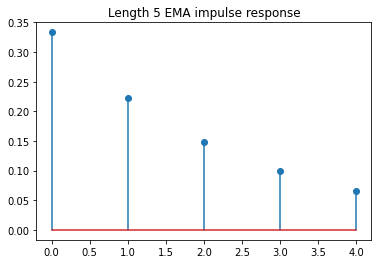

In [78]:
# Run me to plot!
h = ema_filter(5)
plt.figure()
plt.title("Length 5 EMA impulse response")
plt.stem(h)
plt.show()

We can now convolve data with the impulse response to calculate the EMA! Note that if we flipped this signal (as we'd do in convolving) and slid it across some data signal, pointwise multiplying and summing to calculate our EMA, the strongest point would always be at the front, with an exponential drop-off as we go further and further back along the impulse response.

**2 Quick Things to Note:**

1. The LCCDE we originally gave describes an IIR filter, but we are using an FIR filter - after all, we can't store infinitely many values on a computer. In order to account for this, we truncate as is typically done, but we also renormalize so that the sum of the impulse response's coefficients, known as the DC gain, is 1.

2. The value for $\alpha$ that we have picked is motivated by reducing the output noise variance. We have a provided a reference below if you wish to read more about this.

## The MACD Line

The *MACD line* is calculated by taking the difference between the 26-day EMA of the stock and its 12-day EMA. In the cell below, we've defined an array of values, `data`, for you based on the same AAPL stock data we used earlier in this lab. In the cell below, calculate the MACD line. To do so,
- Create a length 26 EMA filter, $h_{26}$.
- Create a length 12 EMA filter, $h_{12}$.
- Calculate the 26-day EMA as $y_{26} = x * h_{26}$, where $x$ is `data`. **Use "valid" as the convolution mode** - we only want points where our signals fully overlap.
- Calculate the 12-day EMA as $y_{12} = x * h_{12}$. Again, use "valid" as the convolution mode.
- Crop $y_{12}$ by discarding its first 14 values, so that $y_{26}$ and $y_{12}$ have the same length. 
    - The first value in $y_{26}$ is an EMA taken over data points 1 through 26 (since the first point the signals fully overlap is at day 26), representing the exponential average at day 26, factoring in the previous 25 days. By cropping out the first 14 values of $y_{12}$, we ensure the first point in its output also corresponds to an EMA for day 26, but taken over the most recent 12 days rather than 26, essentially "aligning" the outputs.
- Compute the MACD line as $y_{12} - y_{26}$. **Store your result in a variable called `MACD`, as our plotting code uses this.**

After you finish, run the next cell to plot the results; here's the plot from the staff solution so you're able to check that your answer is correct before moving on:

<img src="macd.png" width="1100px" />

In [106]:
# Stock data
data = stock_prices[start:end]

# TODO calculate macd line

#length 26 ema filter
h26 = ema_filter(26)
h12 = ema_filter(12)

y26 = np.convolve(data,h26,mode='valid')
y12 = np.convolve(data,h12,mode='valid')
y12 = np.delete(y12,(0,1,2,3,4,5,6,7,8,9,10,11,12,13))
MACD = y12-y26


No handles with labels found to put in legend.


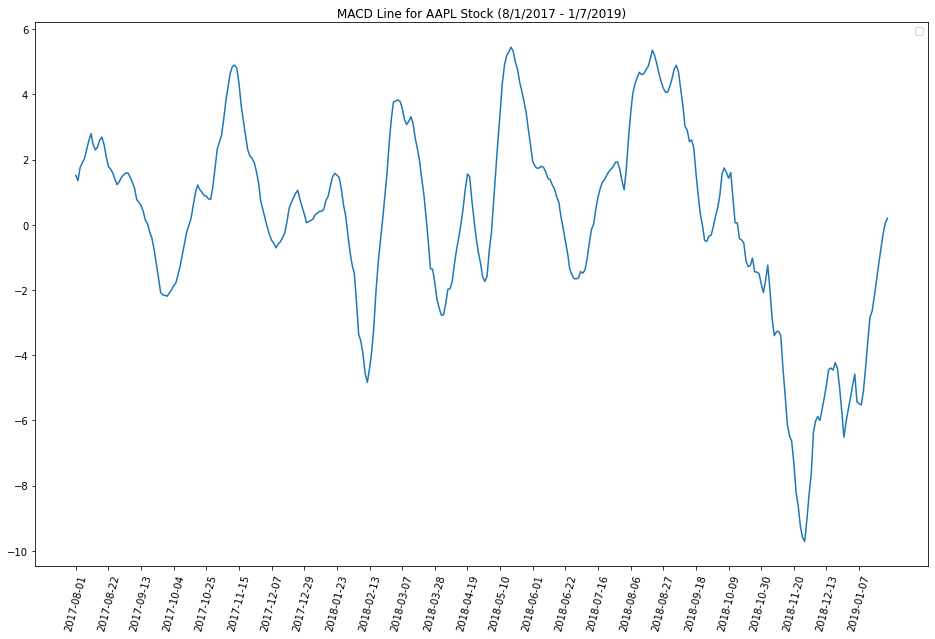

In [107]:
# Plotting Code
x = np.arange(len(MACD))
fig = plt.figure(figsize=(16, 10))
plt.xticks(x[::15], stock_dates[start+26:end:15], fontsize=10, rotation=75)
plt.plot(MACD)
plt.title("MACD Line for AAPL Stock (8/1/2017 - 1/7/2019)")
plt.legend()
plt.show()

## The Signal Line

Now that we have the MACD line, we want to take the 9-day EMA of the MACD line to create the *signal line*. Once equipped with the MACD line and the signal line, we can analyze the stock data. 

Add code in the top of the cell below to calculate the signal line by applying a 9-day EMA filter (use "same" as the convolution mode this time) to your MACD line, `MACD`, from above. Plotting code has been provided for you. **Store the result in a variable called `signal`, as this is what our plotting code uses.**

In [112]:
# TODO your signal line calculation here
h9 = ema_filter(9)
signal = np.convolve(MACD,h9,mode='same')

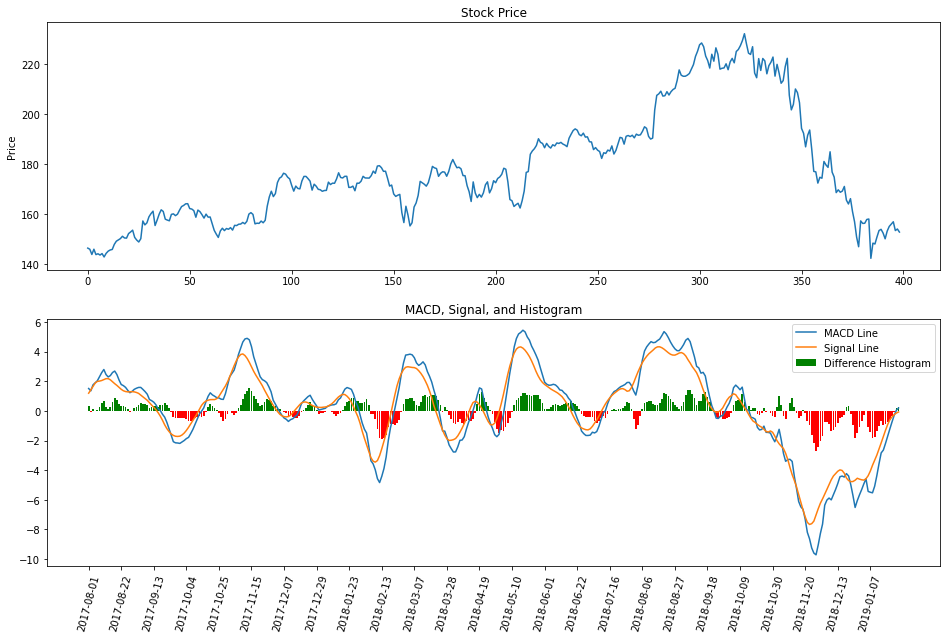

In [113]:
# Plotting Code
c = ['green', 'red']
colors = [c[bool(i)] for i in np.greater(signal, MACD)]
x = np.arange(len(signal))

plt.figure(figsize=(16,10))

plt.subplot(2,1,1)
plt.title("Stock Price")
plt.plot(data)
plt.ylabel("Price")

plt.subplot(2,1,2)
plt.title("MACD, Signal, and Histogram")
plt.xticks(x[::15], stock_dates[start+26:end:15], fontsize=10, rotation=75)
plt.plot(MACD, label='MACD Line')
plt.plot(signal, label='Signal Line')
plt.bar(range(len(signal)),(MACD-signal), color=colors, label="Difference Histogram")
plt.legend()
plt.show()

If done correctly, you should see that the signal line resembles a smoothed, shifted (slightly to the left) version of the MACD line, and the difference histogram is green where the MACD Line is above the signal line, and red where the signal line is above the MACD line.

## Interpretation of the MACD Indicator (from *Technical Analysis* [3])

In signal processing terms, the MACD is a filtered measure of velocity. The velocity has been passed through two first-order linear low-pass filters (the EMA filters). The signal line is that resulting velocity, filtered again. The difference between those two, the histogram, is a measure of the acceleration, with all three filters applied. A MACD crossover of the signal line indicates that the direction of the acceleration is changing. The MACD line crossing zero suggests that the average velocity is changing direction.

**Q:** Using this analogy of velocity and acceleration, we can think of a stock's price as a the position of the car. We know its velocity and acceleration from the MACD and histogram, respectively. What do points where the difference histogram is positive tell us about how the stock is behaving, and how can we use this inforamtion to decide whether or not to invest in a stock? How about when the difference histogram is negative?

<span style="color:blue">**A:** The magnitude of the change that is show tells us how volitile the stock price is and using the analogy the fall of the price indicates deaccelerating which is a good time to buy, when the magnitude of chage drops, we can see that its at constant velocity and green indicates acceleration.</span>

# References
[1] Excerpt from an online signal processing textbook on the use of Moving Average Filters for noise reduction. [Link](https://www.analog.com/media/en/technical-documentation/dsp-book/dsp_book_Ch15.pdf)  
[2] Overview of the MACD indicator. [Link](https://www.investopedia.com/terms/m/macd.asp)  
[3] *Technical Analysis*. [Link](http://www.mrao.cam.ac.uk/~mph/Technical_Analysis.pdf)  
[4] Exponential Moving Average Resource. [Link](https://tttapa.github.io/Pages/Mathematics/Systems-and-Control-Theory/Digital-filters/Exponential%20Moving%20Average/Exponential-Moving-Average.html) 